# Multi-component equilibrium and critical points

In [1]:
using Pkg
Pkg.activate("..")
using Clapeyron, PyCall, CSV, Tables
import PyPlot; const plt = PyPlot

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/UROP/SAFT_codes/Clapeyron`


PyPlot

In this notebook, we will be giving examples of the various equilibrium and critical properties one can obtain in `Clapeyron.jl`. As most of the previous notebooks have shown the more-classic $p-xy$ and $T-xy$ diagrams, this notebook will focus on the uncommon, more-complex types of diagrams.

## $pT$ isopleth of four component mixture

As a first example, we consider a $pT$ isopleth for a four-component systems of a liquid-natural gas system.

Generating the models and defining the mole fraction for the isopleth:

In [124]:
model1 = GERG2008(["methane","butane","isobutane","pentane"])
model2 = PR(["methane","butane","isobutane","pentane"])
model3 = PCSAFT(["methane","butane","isobutane","pentane"])
model4 = SAFTgammaMie(["methane","butane","isobutane","pentane"])

models = [model1,model2,model3,model4]
x = [0.96611,0.01475,0.01527,0.00385];

Obtaining the dew and bubble points of the isopleth. Here, we guestimate the critical point of the mixture and re-use the initial guess to reduce the computational time:

GERG-2008


PR


PCSAFT


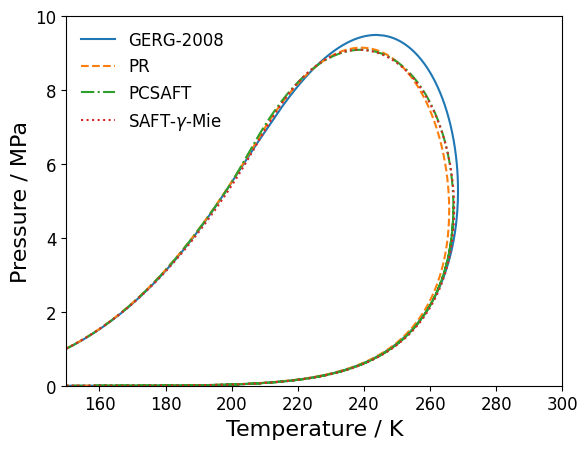

SAFT-$\gamma$-Mie


In [126]:
plt.clf()
eosname = ["GERG-2008","PR","PCSAFT",raw"SAFT-$\gamma$-Mie"]
style = ["-","--","-.",":"]

for i in 1:4
    Tbub = zeros(100)
    pbub = zeros(100)

    idxend = 100

    Tbub[1] = 150.
    bub = bubble_pressure(models[i],Tbub[1],x)
    pbub[1] = bub[1]
    dT = 1.
    v0p = vcat(log10(bub[2]),log10(bub[3]),bub[4])
    for j in 2:2:100
        Tbub[j] = Tbub[j-1] + dT
        bub = bubble_pressure(models[i],Tbub[j],x;v0=v0p)
        pbub[j] = bub[1]

        if bub[3]-bub[2] < 1e-5
            idxend = j-2
            break
        end

        dp = pbub[j]-pbub[j-1]
        pbub[j+1] = pbub[j] + dp
        
        v0T = vcat(Tbub[j],log10(bub[2]),log10(bub[3]),bub[4])
        bub = bubble_temperature(models[i],pbub[j+1],x;v0=v0T)
        Tbub[j+1] = bub[1]
        dT = Tbub[j+1]-Tbub[j]
        if bub[3]-bub[2] < 1e-5
            # println(j)
            idxend = j-1
            break
        end
        v0p = vcat(log10(bub[2]),log10(bub[3]),bub[4])
    end

    Tbub = Tbub[1:idxend]
    pbub = pbub[1:idxend]

    println(eosname[i])

    Tdew = zeros(10000)
    pdew = zeros(10000)

    idxend = 10000

    Tdew[1] = 150.
    dew = dew_pressure(models[i],Tdew[1],x)
    pdew[1] = dew[1]
    dT = 10.
    v0p = vcat(log10(dew[2]),log10(dew[3]),dew[4])
    for j in 2:2:9999
        Tdew[j] = Tdew[j-1] + dT
        dew = dew_pressure(models[i],Tdew[j],x;v0=v0p)
        pdew[j] = dew[1]

        if dew[3]-dew[2] < 1e-5
            idxend = j-2
            break
        end

        dp = pdew[j]-pdew[j-1]
        pdew[j+1] = pdew[j] + dp
        
        v0T = vcat(Tdew[j],log10(dew[2]),log10(dew[3]),dew[4])
        dew = dew_temperature(models[i],pdew[j+1],x;v0=v0T)
        Tdew[j+1] = dew[1]
        dT = Tdew[j+1]-Tdew[j]

        if abs(dT)<1e-3
            dT*=10
        end

        if dew[3]-dew[2] < 1e-5
            idxend = j-1
            break
        end
        v0p = vcat(log10(dew[2]),log10(dew[3]),dew[4])
    end
    Tdew = Tdew[1:idxend]
    pdew = pdew[1:idxend]

    T = vcat(Tbub,reverse(Tdew))
    p = vcat(pbub,reverse(pdew))
    plt.plot(T,p./1e6,label=eosname[i],linestyle=style[i])
end

plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([0.,10.])
plt.xlim([150,300])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

Unsurprisingly, GERG-2008 performs the best in this system; even more-surprising is how similar the predictions from the other equations of state are.

## $pT$ isopleth for 12 component system

Ramping up the difficulty, we now examine a 12 component liquid natural gas system. This is to highlight that `Clapeyron.jl` is able to handle systems of particularly large size. For some of these equations of state, these are the largest systems they've ever been shown to model.

Generating the models and setting the mole fraction for the isopleth:

In [128]:
model1 = GERG2008(["methane","nitrogen","carbon dioxide","ethane","propane","butane","isobutane",
                   "pentane","isopentane","hexane","heptane","octane"])
model2 = SRK(["methane","nitrogen","carbon dioxide","ethane","propane","butane","isobutane",
                   "pentane","isopentane","hexane","heptane","octane"])
model3 = PCSAFT(["methane","nitrogen","carbon dioxide","ethane","propane","butane","isobutane",
                   "pentane","isopentane","hexane","heptane","octane"])
models = [model1,model2,model3]
x = [0.833482,0.056510,0.002840,0.075260,0.020090,0.005200,0.003050,0.001440,0.001200,0.000680,0.000138,0.000110];

As before, we scan the isopleth in three chunks; again, we guestimate the critical point and re-use initial guesses:

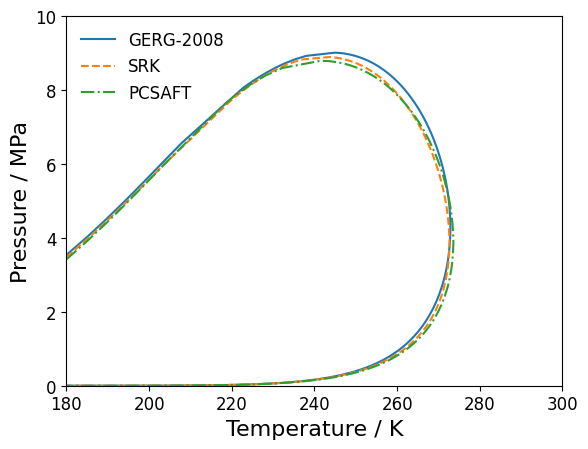

In [129]:
plt.clf()
eosname = ["GERG-2008","SRK","PCSAFT"]
style = ["-","--","-."]

for i in 1:3
    Tbub = zeros(100)
    pbub = zeros(100)

    idxend = 100

    Tbub[1] = 180.
    bub = bubble_pressure(models[i],Tbub[1],x)
    pbub[1] = bub[1]
    dT = 5.
    v0p = vcat(log10(bub[2]),log10(bub[3]),bub[4])
    for j in 2:2:100
        Tbub[j] = Tbub[j-1] + dT
        bub = bubble_pressure(models[i],Tbub[j],x;v0=v0p)
        pbub[j] = bub[1]

        if bub[3]-bub[2] < 1e-5
            idxend = j-2
            break
        end

        dp = pbub[j]-pbub[j-1]
        pbub[j+1] = pbub[j] + dp
        
        v0T = vcat(Tbub[j],log10(bub[2]),log10(bub[3]),bub[4])
        bub = bubble_temperature(models[i],pbub[j+1],x;v0=v0T)
        Tbub[j+1] = bub[1]
        dT = Tbub[j+1]-Tbub[j]
        if bub[3]-bub[2] < 1e-5
            # println(j)
            idxend = j-1
            break
        end
        v0p = vcat(log10(bub[2]),log10(bub[3]),bub[4])
    end

    Tbub = Tbub[1:idxend]
    pbub = pbub[1:idxend]

    Tdew = zeros(10000)
    pdew = zeros(10000)

    idxend = 10000

    Tdew[1] = 180.
    dew = dew_pressure(models[i],Tdew[1],x)
    pdew[1] = dew[1]
    dT = 20.
    v0p = vcat(log10(dew[2]),log10(dew[3]),dew[4])
    
        for j in 2:2:9999
                Tdew[j] = Tdew[j-1] + dT
                dew = dew_pressure(models[i],Tdew[j],x;v0=v0p)
                pdew[j] = dew[1]

                if dew[3]-dew[2] < 1e-5
                    idxend = j-2
                    break
                end

                dp = pdew[j]-pdew[j-1]

                pdew[j+1] = pdew[j] + dp
                
                v0T = vcat(Tdew[j],log10(dew[2]),log10(dew[3]),dew[4])
                dew = dew_temperature(models[i],pdew[j+1],x;v0=v0T)
                Tdew[j+1] = dew[1]
                dT = Tdew[j+1]-Tdew[j]

                if abs(dp/pdew[j]*Tdew[j]/dT)<0.35
                    dT*=5
                end
                if abs(dT/Tdew[j]*pdew[j]/dp)<0.003
                    dT*=-5
                end

                
                if dew[3]-dew[2] < 1e-5
                    idxend = j-1
                    break
                end
                v0p = vcat(log10(dew[2]),log10(dew[3]),dew[4])
        end
    
    Tdew = Tdew[1:idxend]
    pdew = pdew[1:idxend]

    T = vcat(Tbub,reverse(Tdew))
    p = vcat(pbub,reverse(pdew))
    plt.plot(T,p./1e6,label=eosname[i],linestyle=style[i])
end

plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([0.,10.])
plt.xlim([180,300])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

## $pT$ projection of carbon dioxide + ethane

We've shown in previous notebooks how `Clapeyron.jl` can plot the entire phase diagram _for a single component_; in a binary component the `complete' phase diagram is usually referred to as the $pT$ projection where we include the saturation curve for each component and the critical point of the mixture between these two curves. We first choose to model the carbon dioxide + ethane system as the critical curve here has an unusual shape.

Generating the models:

In [130]:
model1 = SRK(["carbon dioxide","ethane"])
model2 = PSRK(["carbon dioxide","ethane"])
model3 = GERG2008(["carbon dioxide","ethane"])
model4 = SAFTVRMie(["carbon dioxide","ethane"])
model5 = sPCSAFT(["carbon dioxide","ethane"])

models = [model1,model2,model3,model4,model5];

We first obtain the saturation curve for each component using each equation of state:

In [131]:
p_1 = zeros(100,5)
p_2 = zeros(100,5)
T_1 = zeros(100,5)
T_2 = zeros(100,5)
for j=1:5
    pure = split_model(models[j])
    crit = crit_pure.(pure)
    T = zeros(100,2)
    p = zeros(100,2)
    sat = []
    for i=1:2
        T[:,i] = range(0.7*crit[i][1],crit[i][1],length=100)
        sat = saturation_pressure.(pure[i],T[:,i])
        p[:,i] = [sat[i][1] for i in 1:100]
    end

    p_1[:,j] = p[:,1]
    p_2[:,j] = p[:,2]

    T_1[:,j] = T[:,1]
    T_2[:,j] = T[:,2]
end

We next solve for the critical points of the mixture using `crit_mix` where one specifies the mole fraction of the mixture:

In [132]:
x = range(1e-5,1-1e-5,length=100)
X = Clapeyron.FractionVector.(x)
T_crit = zeros(100,5)
p_crit = zeros(100,5)
for j=1:5
    v0 = Clapeyron.x0_crit_mix(models[j],X[1])
    for i=1:100
        mix_crit = crit_mix(models[j],X[i];v0=v0)
        v0 = [log10(mix_crit[3]),mix_crit[1]]
        
        T_crit[i,j] = mix_crit[1]
        p_crit[i,j] = mix_crit[2]
    end
end

To reduce computational time, we re-use initial guesses.

Plotting:

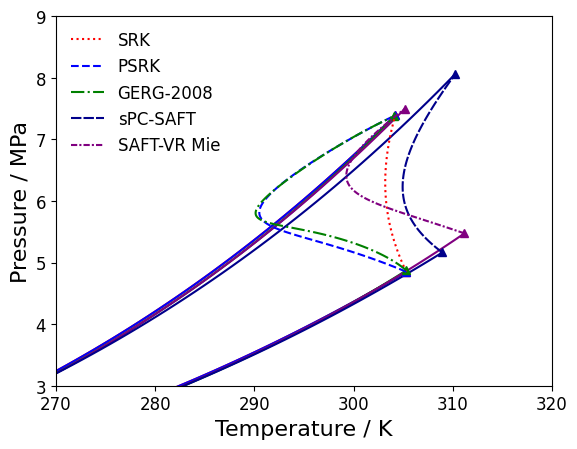

In [134]:
plt.clf()
plt.plot(T_1[:,1],p_1[:,1]./1e6,label="",linestyle="-",color="r")
plt.plot(T_1[:,2],p_1[:,2]./1e6,label="",linestyle="-",color="b")
plt.plot(T_1[:,3],p_1[:,3]./1e6,label="",linestyle="-",color="g")
plt.plot(T_1[:,4],p_1[:,4]./1e6,label="",linestyle="-",color="purple")
plt.plot(T_1[:,5],p_1[:,5]./1e6,label="",linestyle="-",color="darkblue")
plt.plot(T_2[:,1],p_2[:,1]./1e6,label="",linestyle="-",color="r")
plt.plot(T_2[:,2],p_2[:,2]./1e6,label="",linestyle="-",color="b")
plt.plot(T_2[:,3],p_2[:,3]./1e6,label="",linestyle="-",color="g")
plt.plot(T_2[:,4],p_2[:,4]./1e6,label="",linestyle="-",color="purple")
plt.plot(T_2[:,5],p_2[:,5]./1e6,label="",linestyle="-",color="darkblue")
plt.plot(T_1[end,1],p_1[end,1]./1e6,label="",marker="^",linestyle="",color="r")
plt.plot(T_1[end,2],p_1[end,2]./1e6,label="",marker="^",linestyle="",color="b")
plt.plot(T_1[end,3],p_1[end,3]./1e6,label="",marker="^",linestyle="",color="g")
plt.plot(T_1[end,4],p_1[end,4]./1e6,label="",marker="^",linestyle="",color="purple")
plt.plot(T_1[end,5],p_1[end,5]./1e6,label="",marker="^",linestyle="",color="darkblue")
plt.plot(T_2[end,1],p_2[end,1]./1e6,label="",marker="^",linestyle="",color="r")
plt.plot(T_2[end,2],p_2[end,2]./1e6,label="",marker="^",linestyle="",color="b")
plt.plot(T_2[end,3],p_2[end,3]./1e6,label="",marker="^",linestyle="",color="g")
plt.plot(T_2[end,4],p_2[end,4]./1e6,label="",marker="^",linestyle="",color="purple")
plt.plot(T_2[end,5],p_2[end,5]./1e6,label="",marker="^",linestyle="",color="darkblue")

plt.plot(T_crit[:,1],p_crit[:,1]./1e6,label="SRK",linestyle=":",color="r")
plt.plot(T_crit[:,2],p_crit[:,2]./1e6,label="PSRK",linestyle="--",color="b")
plt.plot(T_crit[:,3],p_crit[:,3]./1e6,label="GERG-2008",linestyle="-.",color="g")
plt.plot(T_crit[:,5],p_crit[:,5]./1e6,label="sPC-SAFT",linestyle=(0, (5, 1)),color="darkblue")
plt.plot(T_crit[:,4],p_crit[:,4]./1e6,label="SAFT-VR Mie",linestyle=(0, (3, 1, 1, 1)),color="purple")

plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([3.,9.])
plt.xlim([270,320])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

## $pT$ projection of ethane + decane

In the previous case, we had two components with very similar critical points; now we examine the inverse case where the critical points are different.

Generating the models:

In [244]:
model1 = VTPR(["ethane","decane"])
model2 = GERG2008(["ethane","decane"])
model3 = softSAFT(["ethane","decane"])

models = [model1,model2,model3];

Obtaining the saturation curve for the pure components:

In [247]:
p_1 = zeros(100,3)
p_2 = zeros(100,3)
T_1 = zeros(100,3)
T_2 = zeros(100,3)
for j=1:3
    pure = split_model(models[j])
    crit = crit_pure.(pure)
    T = zeros(100,2)
    p = zeros(100,2)
    sat = []
    for i=1:2
        T[:,i] = range(0.7*crit[i][1],crit[i][1],length=100)
        sat = saturation_pressure.(pure[i],T[:,i])
        p[:,i] = [sat[k][1] for k in 1:100]
    end

    p_1[:,j] = p[:,1]
    p_2[:,j] = p[:,2]

    T_1[:,j] = T[:,1]
    T_2[:,j] = T[:,2]
end

Obtaining the critical point of the mixture at different compositions, re-using initial guesses:

In [250]:
N = 100
x = range(1e-2,1-1e-2,length=N)
X = Clapeyron.FractionVector.(x)
T_crit = zeros(N,3)
p_crit = zeros(N,3)
for j=1:3
    T_crit[1,j] = T_2[end,j]
    p_crit[1,j] = p_2[end,j]

    T_crit[N,j] = T_1[end,j]
    p_crit[N,j] = p_1[end,j]
    v0 = Clapeyron.x0_crit_mix(models[j],X[1])
    for i=2:N-1
        mix_crit = crit_mix(models[j],X[i];v0=v0)
        v0 = [log10(mix_crit[3]),mix_crit[1]]
        
        T_crit[i,j] = mix_crit[1]
        p_crit[i,j] = mix_crit[2]
    end
end

Plotting:

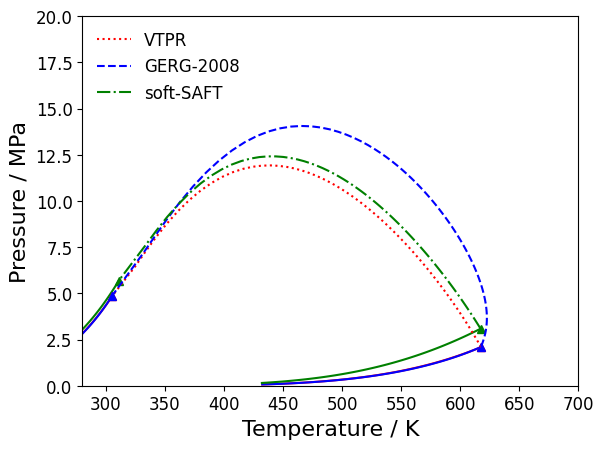

In [251]:
plt.clf()
plt.plot(T_1[:,1],p_1[:,1]./1e6,label="",linestyle="-",color="r")
plt.plot(T_1[:,2],p_1[:,2]./1e6,label="",linestyle="-",color="b")
plt.plot(T_1[:,3],p_1[:,3]./1e6,label="",linestyle="-",color="g")
plt.plot(T_2[:,1],p_2[:,1]./1e6,label="",linestyle="-",color="r")
plt.plot(T_2[:,2],p_2[:,2]./1e6,label="",linestyle="-",color="b")
plt.plot(T_2[:,3],p_2[:,3]./1e6,label="",linestyle="-",color="g")
plt.plot(T_1[end,1],p_1[end,1]./1e6,label="",marker="^",linestyle="",color="r")
plt.plot(T_1[end,2],p_1[end,2]./1e6,label="",marker="^",linestyle="",color="b")
plt.plot(T_1[end,3],p_1[end,3]./1e6,label="",marker="^",linestyle="",color="g")
plt.plot(T_2[end,1],p_2[end,1]./1e6,label="",marker="^",linestyle="",color="r")
plt.plot(T_2[end,2],p_2[end,2]./1e6,label="",marker="^",linestyle="",color="b")
plt.plot(T_2[end,3],p_2[end,3]./1e6,label="",marker="^",linestyle="",color="g")

plt.plot(T_crit[:,1],p_crit[:,1]./1e6,label="VTPR",linestyle=":",color="r")
plt.plot(T_crit[:,2],p_crit[:,2]./1e6,label="GERG-2008",linestyle="--",color="b")
plt.plot(T_crit[:,3],p_crit[:,3]./1e6,label="soft-SAFT",linestyle="-.",color="g")

plt.legend(loc="upper left",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([0.,20.])
plt.xlim([280,700])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

## $pT$ projection of methanol + cyclohexane

In the previous examples, we only considered type-I mixtures. To illustrate how `Clapeyron.jl` can indeed handle different binary phase types, we consider the methanol + cyclohexane system implemented in PC-SAFT. Here, we first obtain the upper critical end point of the mixture (where the UCST curve meets the VLLE and azeotrope curve). From here, we scan for the UCST, VLLE and azeotrope curves. The saturation and critical curves are obtained as before:

In [252]:
model = PCSAFT(["methanol","cyclohexane"])
pure  = Clapeyron.split_model(model)

2-element Vector{PCSAFT{BasicIdeal, Float64}}:
 PCSAFT{BasicIdeal, Float64}("methanol")
 PCSAFT{BasicIdeal, Float64}("cyclohexane")

Get the pure critical points and saturation curves:

In [280]:
crit = crit_pure.(pure)

T_1 = range(310,crit[1][1],length=200)
T_2 = range(310,crit[2][1],length=200)

sat_1 = saturation_pressure.(pure[1],T_1)
sat_2 = saturation_pressure.(pure[2],T_2)

p_1 = [sat_1[i][1] for i in 1:200]
p_2 = [sat_2[i][1] for i in 1:200];

Get the UCEP for the mixture:

In [254]:
UCEP = UCEP_mix(model);

Get the VLLE curve:

In [288]:
T_3 = range(310,UCEP[1],length=200)
v0 = Clapeyron.x0_VLLE_pressure(model,T_3[1])

p_3 = zeros(200)

for i in 1:200
    vlle = VLLE_pressure(model,T_3[i];v0=v0)
    p_3[i] = vlle[1]
    v0  = [log10(vlle[2]),log10(vlle[3]),log10(vlle[4]),vlle[5][1],vlle[6][1],vlle[7][1]]
end


Get the critical curve:

In [281]:
x = range(1e-5,1-1e-5,length=200)
X = Clapeyron.FractionVector.(x)

T_4 = zeros(200)
p_4 = zeros(200)

v0 = Clapeyron.x0_crit_mix(model,X[1])

for i in 1:200
    crit_bin = crit_mix(model,X[i];v0=v0)
    T_4[i] = crit_bin[1]
    p_4[i] = crit_bin[2]
    v0 = [log10(crit_bin[3]),crit_bin[1]]
end

Get the azeotrope curve:

In [293]:
T_5 = range(UCEP[1],520,length=200)
v0 = Clapeyron.x0_azeotrope_pressure(model,T_5[1])

p_5 = zeros(200)

for i in 1:200
    az = azeotrope_pressure(model,T_5[i];v0=v0)
    p_5[i] = az[1]
    v0  = az[4]
end

Get UCST curve:

In [305]:
T_6 = range(UCEP[1],UCEP[1]*1.5,length=200)

v0 = hcat(log10(UCEP[3]),[UCEP[5]])

p_6 = zeros(200)

for i in 1:200
    ucst = UCST_mix(model,T_6[i];v0=v0)
    p_6[i] = ucst[1]
    v0 = [log10(ucst[2]),ucst[3]]
end

Plotting:

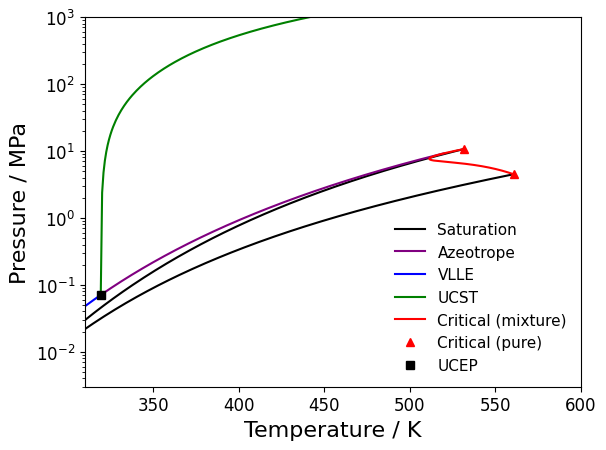

In [309]:
plt.clf()
plt.plot(T_1,p_1./1e6,label="Saturation",color="k")
plt.plot(T_2,p_2./1e6,label="",color="k")
plt.plot(T_5,p_5./1e6,label="Azeotrope",color="purple")
plt.plot(T_3,p_3./1e6,label="VLLE",color="blue")
plt.plot(T_6,p_6./1e6,label="UCST",color="green")
plt.plot(T_4,p_4./1e6,label="Critical (mixture)",color="r")

plt.semilogy(crit[1][1],crit[1][2]./1e6,label="Critical (pure)",linestyle="",color="red",marker="^")
plt.plot(crit[2][1],crit[2][2]./1e6,label="",linestyle="",color="red",marker="^")
plt.plot(UCEP[1],UCEP[2]./1e6,label="UCEP",linestyle="",color="k",marker="s")

plt.legend(loc="lower right",frameon=false,fontsize=11) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([3e-3,1e3])
plt.xlim([310,600])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

## $p-xxy$ diagram of methanol + ethane

In all the previous notebooks, we only considered VLE envelopes of binary components. However, binary phase diagrams can become more-complicated than this as we can include VLE, LLE and VLLE. To illustrate that these diagrams can be plotted in `Clapeyron.jl`, we consider the methanol + ethane system.

Generating the models:

In [310]:
model1 = PCSAFT(["methanol","ethane"])
model2 = SAFTgammaMie(["methanol","ethane"])
model3 = PR(["methanol","ethane"])

PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule} with 2 components:
 "methanol"
 "ethane"
Contains parameters: a, b, Tc, Pc, Mw

By providing a good initial guess, we can obtain the VLLE point, from which we can scan for the VLE and LLE envelopes (as before, we re-use initial guesses). For PC-SAFT:

In [328]:
VLLE_PC

(4.1166810242142193e6, 5.6841902163748695e-5, 8.98985435421196e-5, 0.00032156188587739536, [0.4366186705639324, 0.5633813294360677], [0.028489575313341082, 0.9715104246866589], [0.00462396035936605, 0.9953760396406339])

In [366]:
VLLE_PC=VLLE_pressure(model1,298.15;v0 = [log10(4e-5),log10(9e-5),log10(3e-4),0.8,0.1,0.01])
x1_PC = range(1e-6,VLLE_PC[6][1],length=100)
x2_PC = range(VLLE_PC[5][1],1-1e-6,length=100)
x3_PC = range(VLLE_PC[6][1],5*VLLE_PC[6][1],length=100)

X1 = Clapeyron.FractionVector.(x1_PC)
X2 = Clapeyron.FractionVector.(x2_PC)
X3 = Clapeyron.FractionVector.(x3_PC)

bub1 = bubble_pressure.(model1,298.15,X1)
bub2 = bubble_pressure.(model1,298.15,X2)

p1_PC = [bub1[i][1] for i ∈ 1:100]
p2_PC = [bub2[i][1] for i ∈ 1:100]

y1_PC = [bub1[i][4][1] for i ∈ 1:100]
y2_PC = [bub2[i][4][1] for i ∈ 1:100]

z0 = (VLLE_PC[5]+VLLE_PC[6])/2
p3_PC = range(VLLE_PC[1],6e6,length=100)
x3_PC = zeros(100)
y3_PC = zeros(100)

for i in 1:100
    (x,n,G) = tp_flash(model1,p3_PC[i],298.15,z0,MichelsenTPFlash(equilibrium=:lle))
    x3_PC[i] = x[1,1]
    y3_PC[i] = x[2,1]
    K0 = x[1,:]./x[2,:]
end

For SAFT-γ Mie:

In [371]:
VLLE_gamma=VLLE_pressure(model2,298.15;v0 = [log10(5e-5),log10(9e-5),log10(3e-4),0.8,0.1,0.01])
x1_gamma = range(1e-6,VLLE_gamma[6][1],length=100)
x2_gamma = range(VLLE_gamma[5][1],1-1e-6,length=100)

X1 = Clapeyron.FractionVector.(x1_gamma)
X2 = Clapeyron.FractionVector.(x2_gamma)

bub1 = bubble_pressure.(model2,298.15,X1)
bub2 = bubble_pressure.(model2,298.15,X2)

p1_gamma = [bub1[i][1] for i ∈ 1:100]
p2_gamma = [bub2[i][1] for i ∈ 1:100]

y1_gamma = [bub1[i][4][1] for i ∈ 1:100]
y2_gamma = [bub2[i][4][1] for i ∈ 1:100]

z0 = (VLLE_gamma[5]+VLLE_gamma[6])/2
p3_gamma = range(VLLE_gamma[1],6e6,length=100)
x3_gamma = zeros(100)
y3_gamma = zeros(100)

for i in 1:100
    (x,n,G) = tp_flash(model2,p3_gamma[i],298.15,z0,MichelsenTPFlash(equilibrium=:lle))
    x3_gamma[i] = x[1,1]
    y3_gamma[i] = x[2,1]
    K0 = x[1,:]./x[2,:]
end

For PR:

In [381]:
VLLE_PR=VLLE_pressure(model3,298.15;v0 = [log10(5e-5),log10(7e-5),log10(4e-4),0.6,0.2,0.01])

x1_PR = range(1e-6,VLLE_PR[6][1],length=100)
x2_PR = range(1-1e-6,VLLE_PR[5][1],length=100)

X1 = Clapeyron.FractionVector.(x1_PR)
X2 = Clapeyron.FractionVector.(x2_PR)

v0_1 = Clapeyron.x0_bubble_pressure(model3,298.15,X1[1])
v0_2 = Clapeyron.x0_bubble_pressure(model3,298.15,X2[2])

p1_PR = zeros(100)
p2_PR = zeros(100)

y1_PR = zeros(100)
y2_PR = zeros(100)

z0 = (VLLE_PR[5]+VLLE_PR[6])/2
K0 = VLLE_PR[5]./VLLE_PR[6]
p3_PR = range(VLLE_PR[1],6e6,length=100)
x3_PR = zeros(100)
y3_PR = zeros(100)

for i in 1:100

    bub1 = bubble_pressure(model3,298.15,X1[i];v0=v0_1)
    bub2 = bubble_pressure(model3,298.15,X2[i];v0=v0_2)

    p1_PR[i] = bub1[1]
    p2_PR[i] = bub2[1]

    y1_PR[i] = bub1[4][1]
    y2_PR[i] = bub2[4][1]

    v0_1 = vcat(log10(bub1[2]),log10(bub1[3]),bub1[4])
    v0_2 = vcat(log10(bub2[2]),log10(bub2[3]),bub2[4])

    (x,n,G) = tp_flash(model3,p3_PR[i],298.15,z0,RRTPFlash(K0=K0))
    x3_PR[i] = x[1,1]
    y3_PR[i] = x[2,1]
    K0 = x[1,:]./x[2,:]
end

Plotting:

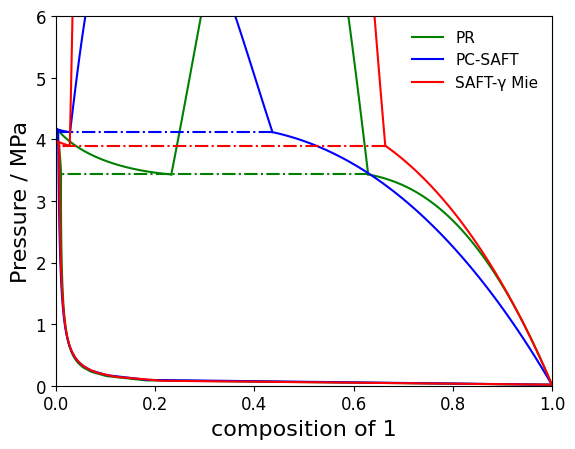

In [382]:
plt.clf()
plt.plot(y1_PR,p1_PR./1e6,label="PR",linestyle="-",color="g")
plt.plot(x1_PR,p1_PR./1e6,label="",linestyle="-",color="g")

plt.plot(y2_PR,p2_PR./1e6,label="",linestyle="-",color="g")
plt.plot(x2_PR,p2_PR./1e6,label="",linestyle="-",color="g")
plt.plot(y3_PR,p3_PR./1e6,label="",linestyle="-",color="g")
plt.plot(x3_PR,p3_PR./1e6,label="",linestyle="-",color="g")

plt.plot([VLLE_PR[5][1],VLLE_PR[6][1],VLLE_PR[7][1]],[VLLE_PR[1],VLLE_PR[1],VLLE_PR[1]]./1e6,label="",linestyle="-.",color="g")

plt.plot(y1_PC,p1_PC./1e6,label="PC-SAFT",linestyle="-",color="b")
plt.plot(x1_PC,p1_PC./1e6,label="",linestyle="-",color="b")

plt.plot(y2_PC,p2_PC./1e6,label="",linestyle="-",color="b")
plt.plot(x2_PC,p2_PC./1e6,label="",linestyle="-",color="b")
plt.plot(y3_PC,p3_PC./1e6,label="",linestyle="-",color="b")
plt.plot(x3_PC,p3_PC./1e6,label="",linestyle="-",color="b")

plt.plot([VLLE_PC[5][1],VLLE_PC[6][1],VLLE_PC[7][1]],[VLLE_PC[1],VLLE_PC[1],VLLE_PC[1]]./1e6,label="",linestyle="-.",color="b")


plt.plot(y1_gamma,p1_gamma./1e6,label="SAFT-γ Mie",linestyle="-",color="r")
plt.plot(x1_gamma,p1_gamma./1e6,label="",linestyle="-",color="r")

plt.plot(y2_gamma,p2_gamma./1e6,label="",linestyle="-",color="r")
plt.plot(x2_gamma,p2_gamma./1e6,label="",linestyle="-",color="r")
plt.plot(y3_gamma,p3_gamma./1e6,label="",linestyle="-",color="r")
plt.plot(x3_gamma,p3_gamma./1e6,label="",linestyle="-",color="r")

plt.plot([VLLE_gamma[5][1],VLLE_gamma[6][1],VLLE_gamma[7][1]],[VLLE_gamma[1],VLLE_gamma[1],VLLE_gamma[1]]./1e6,label="",linestyle="-.",color="r")

plt.legend(loc="upper right",frameon=false,fontsize=11) 

plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.ylim([0,6])
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
display(plt.gcf())

## $T-xxy$ diagram for methanol + cyclohexane

Showing how we can also produce $T-xxy$ diagrams which contain VLE, LLE and VLLE regions using `Clapeyron.jl`, we consider the methanol + cyclohexane system.

Generating the models:

In [18]:
model1 = VTPR(["methanol",("cyclohexane",["CY-CH2" => 6])])
model2 = PCSAFT(["methanol","cyclohexane"])
model3 = SRK(["methanol","cyclohexane"])

RK{BasicIdeal, SoaveAlpha, NoTranslation, vdW1fRule} with 2 components:
 "methanol"
 "cyclohexane"
Contains parameters: a, b, Tc, Pc, Mw

In [14]:
model1

UNIFAC{PR{BasicIdeal, PRAlpha, NoTranslation, vdW1fRule}} with 2 components:
 "methanol": "CH3OH" => 1
 "cyclohexane": "CY-CH2" => 6
Group Type: UNIFACDortmund
Contains parameters: A, B, C, R, Q

By providing a good initial guess, we can obtain the VLLE point, from which we can scan for the VLE and LLE envelopes (as before, we re-use initial guesses). For VT-PR:

In [54]:
x1_VTPR = range(1e-5,1-1e-5,length=200)
X = Clapeyron.FractionVector.(x1_VTPR)

bub = bubble_temperature.(model1,1.013e5,X)

T1_VTPR = [bub[i][1] for i ∈ 1:200]
y1_VTPR = [bub[i][4][1] for i ∈ 1:200]

T2_VTPR = LinRange(295,minimum(T1_VTPR),200)
y2_VTPR = zeros(200)
x2_VTPR = zeros(200)
z0 = [0.5,0.5]
K0 = [100.,1e-2]
idxend = 200
for i in 1:200
    (x,n,G) = tp_flash(model1,1.013e5,T2_VTPR[i],z0,MichelsenTPFlash(equilibrium=:lle,K0=K0))
    y2_VTPR[i] = x[1,1]
    x2_VTPR[i] = x[2,1]
    z0 = (x[1,:]+x[2,:])/2
    K0 = x[1,:]./x[2,:]
    if abs(x[1,1]-x[2,1])<1e-5
        idxend=i
        break 
    end
end
x2_VTPR = x2_VTPR[1:idxend]
y2_VTPR = y2_VTPR[1:idxend]
T2_VTPR = T2_VTPR[1:idxend];

For PC-SAFT:

In [48]:
x1_PC = range(1e-5,1-1e-5,length=200)
X = Clapeyron.FractionVector.(x1_PC)

bub = bubble_temperature.(model2,1.013e5,X)

T1_PC = [bub[i][1] for i ∈ 1:200]
y1_PC = [bub[i][4][1] for i ∈ 1:200]

T2_PC = LinRange(295,minimum(T1_PC),200)
y2_PC = zeros(200)
x2_PC = zeros(200)
z0 = [0.5,0.5]
idxend = 200
for i in 1:200
    (x,n,G) = tp_flash(model2,1.013e5,T2_PC[i],z0,MichelsenTPFlash(equilibrium=:lle))
    y2_PC[i] = x[1,1]
    x2_PC[i] = x[2,1]
    z0 = (x[1,:]+x[2,:])/2
    if abs(x[1,1]-x[2,1])<1e-5
        idxend=i
        break 
    end
end
x2_PC = x2_PC[1:idxend]
y2_PC = y2_PC[1:idxend]
T2_PC = T2_PC[1:idxend];

For PR:

In [47]:
x1_PR = range(1e-5,1-1e-5,length=200)
X = Clapeyron.FractionVector.(x1_PR)

bub = bubble_temperature.(model3,1.013e5,X)

T1_PR = [bub[i][1] for i ∈ 1:200]
y1_PR = [bub[i][4][1] for i ∈ 1:200]

T2_PR = LinRange(295,minimum(T1_PR),200)
y2_PR = zeros(200)
x2_PR = zeros(200)
z0 = [0.5,0.5]
idxend = 200
for i in 1:200
    (x,n,G) = tp_flash(model3,1.013e5,T2_PR[i],z0,MichelsenTPFlash(equilibrium=:lle))
    y2_PR[i] = x[1,1]
    x2_PR[i] = x[2,1]
    z0 = (x[1,:]+x[2,:])/2
    if abs(x[1,1]-x[2,1])<1e-5
        idxend=i
        break 
    end
end
x2_PR = x2_PR[1:idxend]
y2_PR = y2_PR[1:idxend]
T2_PR = T2_PR[1:idxend];

Plotting:

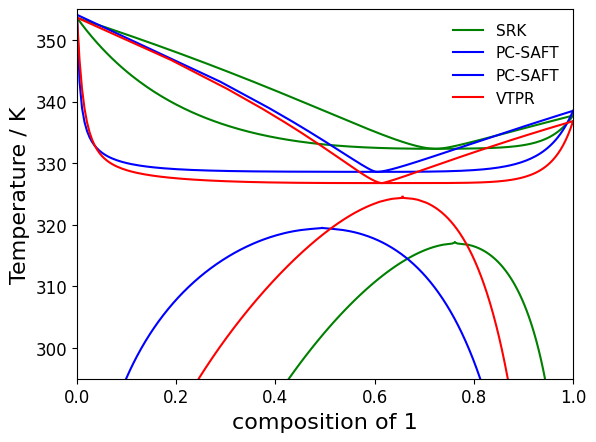

In [55]:
plt.clf()
plt.plot(y1_PR,T1_PR,label="SRK",color="g")
plt.plot(x1_PR,T1_PR,label="",color="g")

plt.plot(y2_PR,T2_PR,label="",color="g")
plt.plot(x2_PR,T2_PR,label="",color="g")

plt.plot(y1_PC,T1_PC,label="PC-SAFT",color="b")
plt.plot(x1_PC,T1_PC,label="",color="b")

plt.plot(y2_PC,T2_PC,label="PC-SAFT",color="b")
plt.plot(x2_PC,T2_PC,label="",color="b")

plt.plot(y1_VTPR,T1_VTPR,label="VTPR",color="r")
plt.plot(x1_VTPR,T1_VTPR,label="",color="r")

plt.plot(y2_VTPR,T2_VTPR,label="",color="r")
plt.plot(x2_VTPR,T2_VTPR,label="",color="r")

plt.legend(loc="upper right",frameon=false,fontsize=11) 

plt.xlabel("composition of 1",fontsize=16)
plt.ylabel("Temperature / K",fontsize=16)
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(295,355)
display(plt.gcf())